In [1]:
import pandas as pd
import numpy as np

In [2]:
# Get the data from local drive
from google.colab import files
uploaded = files.upload()

Saving bank-full.csv to bank-full.csv


In [3]:
# Read the data in, delimiter is ; instead of ,
df=pd.read_csv('bank-full.csv', sep = ';')

print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [4]:
# Only keep the columns mentioned in the home work
del df['default']
del df['loan']
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
# Split the data
from sklearn.model_selection import train_test_split

In [6]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

In [7]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

In [8]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [9]:
# Unshuffle the indicies for tidyness
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
# Set up Y variable
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [11]:
# Delete y from train, val and test dataset as it's our target variable
del df_train['y']
del df_val['y']
del df_test['y']

## **Question 1: ROC AUC feature importance**
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

balance
day
duration
previous

In [12]:
# List of numerical variables I'll use
numerical = ['age', 'balance', 'day', 'campaign','pdays','previous','duration']

In [13]:
from sklearn.metrics import auc

In [14]:
from sklearn.metrics import roc_auc_score

In [15]:
auc_scores =[]
for col in numerical:
  auc_score = roc_auc_score( y_train, df_train[col])

  if auc_score < 0.5:
    auc_score = roc_auc_score( y_train, -df_train[col])

  auc_scores.append(auc_score)

df_as = pd.DataFrame({'Variable': numerical, 'AUC': auc_scores})

df_as

,Variable,AUC
0,age,0.507215
1,balance,0.586832
2,day,0.525017
3,campaign,0.568282
4,pdays,0.594090
5,previous,0.603446
6,duration,0.806563


In [16]:
roc_auc_score( y_train, df_train['balance'])

0.5868318909887845

In [ ]:
roc_auc_score( y_train, df_train['day'])

0.4749832093850958

In [ ]:
roc_auc_score( y_train, df_train['duration'])

0.8065630842212128

In [ ]:
roc_auc_score( y_train, df_train['previous'])

0.6034457341820259

Duration has the highest AUC

### **Question 2: Training the model**
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.69
0.79
0.89
0.99

In [17]:
from sklearn.feature_extraction import DictVectorizer

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
# One hot encoding
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

dicts_val = df_val.to_dict(orient='records')
X_val = dv.transform(dicts_val)


In [20]:
# Train Model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [21]:
y_pred = model.predict_proba(X_val)[:,1]

In [23]:
roc_auc_score(y_val, y_pred).round(3)

0.911

## **Question 3: Precision and Recall**
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.265
0.465
0.665
0.865

In [33]:
y_val

array(['no', 'no', 'yes', ..., 'no', 'no', 'yes'], dtype=object)

In [34]:
scores = []


thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == "yes")
    actual_negative = (y_val == "no")

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp= (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [35]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1070,7972,0,0
10,0.1,932,1505,138,6467
20,0.2,728,687,342,7285
30,0.3,573,419,497,7553
40,0.4,462,286,608,7686
50,0.5,371,197,699,7775
60,0.6,293,131,777,7841
70,0.7,223,96,847,7876
80,0.8,152,64,918,7908
90,0.9,83,27,987,7945


In [37]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [38]:
import matplotlib.pyplot as plt

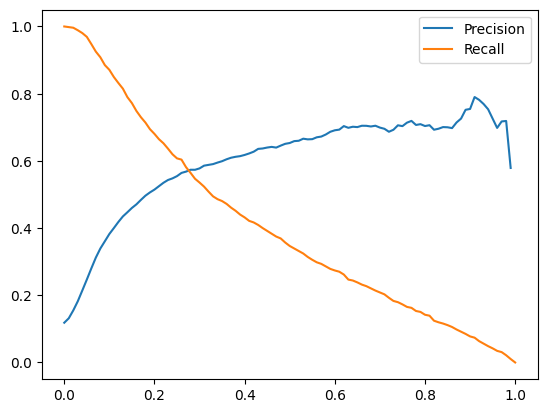

In [39]:
plt.plot(df_scores.threshold, df_scores['precision'], label = 'Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label = 'Recall')
plt.legend()

In [42]:
df_scores['diff'] = np.abs(df_scores['precision'] - df_scores['recall'])

In [45]:
optimal_row = df_scores.loc[df_scores['diff'].idxmin()]

In [46]:
optimal_threshold = optimal_row['threshold']
optimal_precision = optimal_row['precision']
optimal_recall = optimal_row['recall']

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Precision: {optimal_precision}")
print(f"Recall: {optimal_recall}")

Optimal Threshold: 0.28
Precision: 0.5735992402659069
Recall: 0.5644859813084112


## **Question 4: F1 score**
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.02
0.22
0.42
0.62

In [47]:
df_scores['f1'] = 2 * ((df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall']))

In [48]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall,diff,f1
0,0.00,1070,7972,0,0,0.118337,1.000000,0.881663,0.211630
1,0.01,1068,7050,2,922,0.131559,0.998131,0.866571,0.232477
2,0.02,1066,5808,4,2164,0.155077,0.996262,0.841185,0.268379
3,0.03,1058,4748,12,3224,0.182225,0.988785,0.806560,0.307737
4,0.04,1049,3848,21,4124,0.214213,0.980374,0.766161,0.351600
...,...,...,...,...,...,...,...,...,...
96,0.96,37,16,1033,7956,0.698113,0.034579,0.663534,0.065895
97,0.97,33,13,1037,7959,0.717391,0.030841,0.686550,0.059140
98,0.98,23,9,1047,7963,0.718750,0.021495,0.697255,0.041742
99,0.99,11,8,1059,7964,0.578947,0.010280,0.568667,0.020202


In [49]:
max_f1_row = df_scores.loc[df_scores['f1'].idxmax()]

In [50]:
optimal_threshold = max_f1_row['threshold']
max_f1_score = max_f1_row['f1']

print(f"Threshold with Max F1: {optimal_threshold}")
print(f"Max F1 Score: {max_f1_score}")

Threshold with Max F1: 0.22
Max F1 Score: 0.5877894736842105


### **Question 5: 5-Fold CV**
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

In [51]:
from sklearn.model_selection import KFold

In [52]:
kfold = KFold(n_splits = 5, shuffle= True, random_state = 1 )

In [53]:
train_idx, val_idx =next(kfold.split(df_full_train))

In [54]:
len(train_idx), len(val_idx)

(28934, 7234)

In [55]:
len(df_full_train)

36168

In [61]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [58]:
from tqdm.auto import tqdm

In [62]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [70]:
columns = list(df.columns)
columns.remove('y')
columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

In [74]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=1.0)
        y_pred = predict(df_val, dv,model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

print('C = %s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C = 10 0.906 +- 0.008


### **Question 6: Hyperparameter Tuning**
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.000001
0.001
1

In [75]:
n_splits = 5

for C in tqdm([0.000001, 0.001,1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv,model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C = %s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C = 1e-06 0.695 +- 0.009
C = 0.001 0.861 +- 0.006
C = 1 0.906 +- 0.008
